In [1]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy


In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

In [3]:
data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')
data.shape

(995978, 279)

In [5]:
test_ind = [1,10,100]
new_data = np.delete(data,test_ind,axis=0)
new_data.shape

(995975, 279)

**Using mean,std,Rs,Rp,gp  as features**

In [6]:
train_data = new_data
new_spec = np.zeros_like(train_data[:,:274])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp
    new_spec[i,269] = mean_sp
    new_spec[i,270] = std_sp
    new_spec[i,271] = train_data[i,269]   # rstar
    new_spec[i,272] = train_data[i,270]   # rplanet
    new_spec[i,273] = train_data[i,271]   # gp
new_spec.shape

(995975, 274)

## 10K Data 

In [8]:
X = new_spec[:10000]
Y = new_data[:10000,272:]
X.shape, Y.shape

((10000, 274), (10000, 7))

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 274, 1), (2000, 274, 1), (8000, 7), (2000, 7))

In [12]:
import tensorflow as tf

2024-08-30 13:48:16.863151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 13:48:16.863286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 13:48:17.009493: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
# Define the CNN model
def create_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='linear'))
    return model

# Instantiate and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
model_10k = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(1e-4)
model_10k.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model_10k.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 272, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 136, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 134, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 67, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 65, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,130,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,178,119 (8.31 MB)

 Trainable params: 2,178,119 (8.31 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
exolab=model_10k.fit(X_train, y_train, epochs=50,batch_size=32,
                    validation_split=0.2,shuffle=True)

Epoch 1/50
 46/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8513 - mae: 0.7905 - r2_score: 0.1469

I0000 00:00:1725025714.084759      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.6516 - mae: 0.6686 - r2_score: 0.3477 - val_loss: 0.3753 - val_mae: 0.4874 - val_r2_score: 0.6241
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3612 - mae: 0.4742 - r2_score: 0.6350 - val_loss: 0.3134 - val_mae: 0.4366 - val_r2_score: 0.6860
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3118 - mae: 0.4336 - r2_score: 0.6857 - val_loss: 0.2899 - val_mae: 0.4140 - val_r2_score: 0.7095
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2822 - mae: 0.4091 - r2_score: 0.7154 - val_loss: 0.2610 - val_mae: 0.3900 - val_r2_score: 0.7383
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2606 - mae: 0.3904 - r2_score: 0.7390 - val_loss: 0.2415 - val_mae: 0.3747 - val_r2_score: 0.7579
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2404 - mae: 0.3731 - r2_score: 0.7583 - val_loss: 0.2330 - val_mae: 0.3601 - val_r2_score: 0.7664
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

In [15]:
model_10k.save("cnn_model_10k_m_s_p.keras")

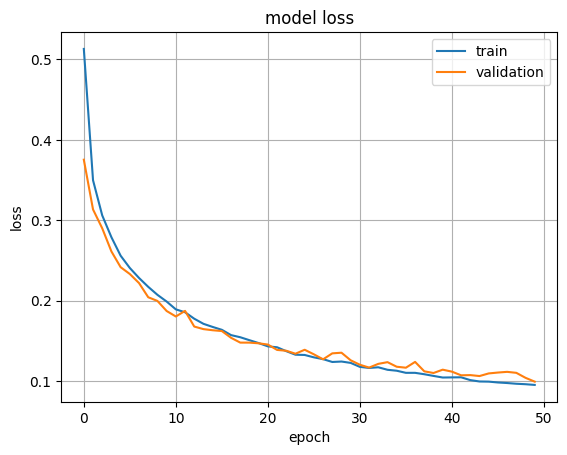

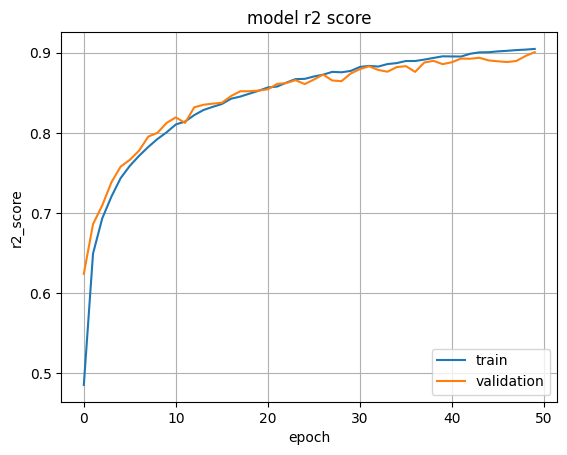

In [16]:
# loss
plt.plot(exolab.history['loss'])
plt.plot(exolab.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

# r2 score
plt.plot(exolab.history['r2_score'])
plt.plot(exolab.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [17]:
test_loss,test_mae,test_r2_score = model_10k.evaluate(X_test,y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0939 - mae: 0.2105 - r2_score: 0.9063


In [18]:
predictions = model_10k.predict(X_test)
predictions.shape

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


(2000, 7)

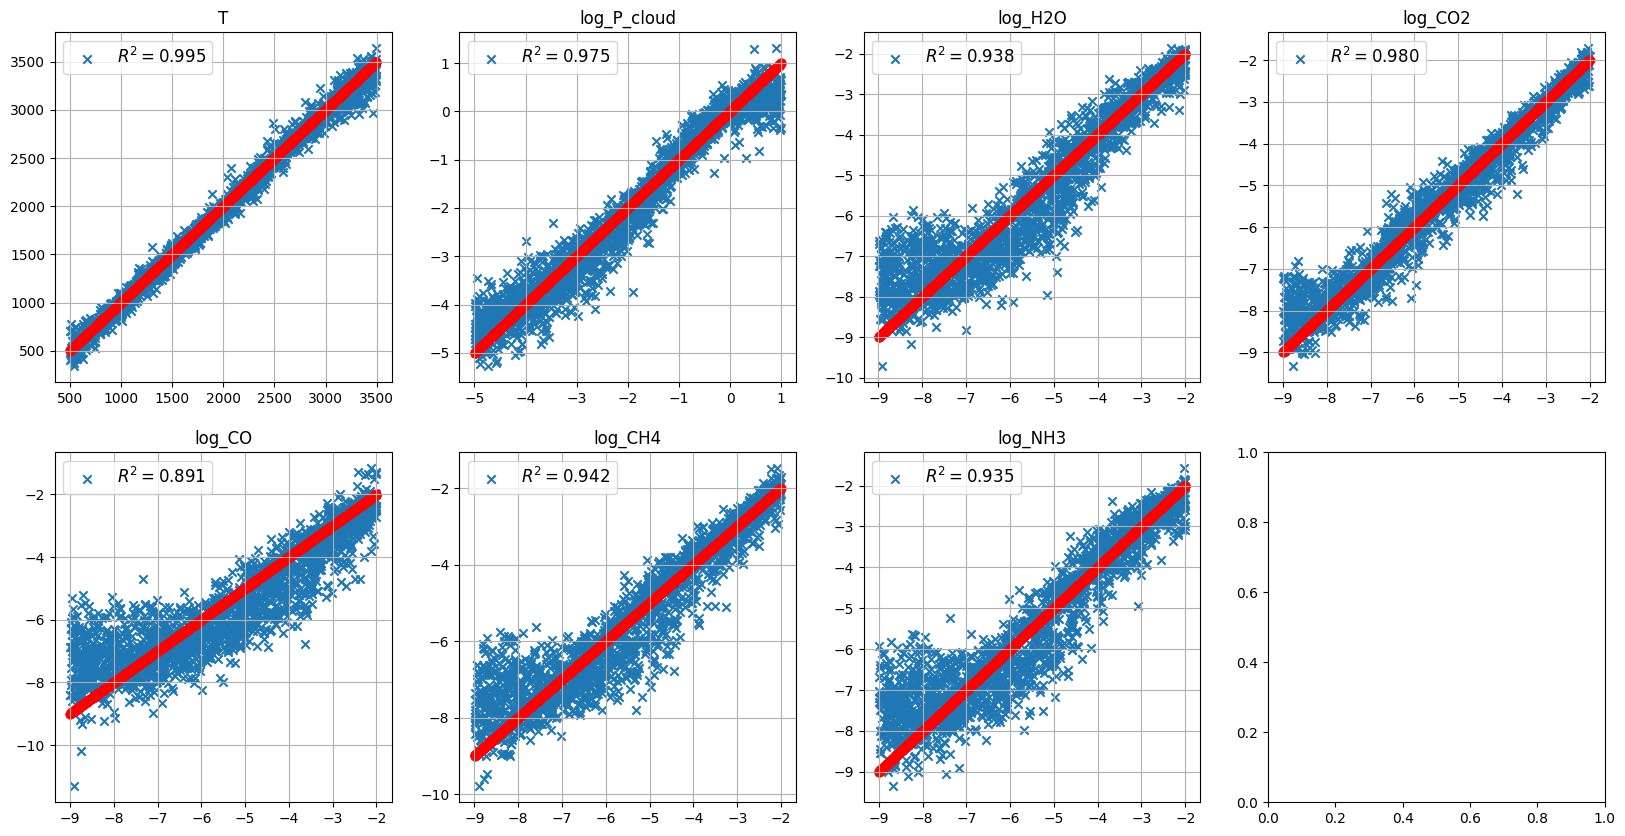

In [19]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

### Testing on the retrieved planets

In [20]:
file_data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')

In [21]:
# planetA data[5,269:]
# planetB data[93906,269:]
# planetC data[20527,269:]

In [22]:
mean = np.mean(file_data[1,:269])
std = np.std(file_data[1,:269])
planetA_spec = (file_data[1,:269] - mean) / std
planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std]),np.array([file_data[1,269]]), np.array([file_data[1,270]]), np.array([file_data[1,271]])])
planetA_params = file_data[1,269:]
planetA_spec.shape, planetA_params.shape

((274,), (10,))

In [23]:
mean = np.mean(file_data[10,:269])
std = np.std(file_data[10,:269])
planetB_spec = (file_data[10,:269] - mean) / std
planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std]),np.array([file_data[10,269]]), np.array([file_data[10,270]]), np.array([file_data[10,271]])])
planetB_params = file_data[10,269:]
planetB_spec.shape, planetB_params.shape

((274,), (10,))

In [24]:
mean = np.mean(file_data[100,:269])
std = np.std(file_data[100,:269])
planetC_spec = (file_data[100,:269] - mean) / std
planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std]),np.array([file_data[100,269]]), np.array([file_data[100,270]]), np.array([file_data[100,271]])])
planetC_params = file_data[100,269:]
planetC_spec.shape, planetC_params.shape

((274,), (10,))

In [25]:
test_planets = np.array([planetA_spec,planetB_spec,planetC_spec])
test_planets = test_planets.reshape(3,274,1)
test_planets.shape

(3, 274, 1)

In [26]:
pred = model_10k.predict(test_planets)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


W0000 00:00:1725025764.051485      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(3, 7)

In [27]:
pred = scaler.inverse_transform(pred)

In [28]:
planetA_pred_10k = pred[0]
print("Predicted values:",planetA_pred_10k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.0042373e+03  5.1074680e-02 -7.0731936e+00 -8.4753389e+00
 -4.7458172e+00 -3.8208728e+00 -4.0681190e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [29]:
planetB_pred_10k = pred[1]
print("Predicted values:",planetB_pred_10k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.0602616e+03  2.6223582e-01 -2.8589783e+00 -2.9365399e+00
 -6.6333041e+00 -5.9330826e+00 -5.2835965e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [30]:
planetC_pred_10k = pred[2]
print("Predicted values:",planetC_pred_10k)
print("Actual values:",planetC_params[3:])

Predicted values: [2503.2202      -3.2532449   -6.4845805   -5.296626    -7.9262533
   -3.0669043   -6.5952315]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 100K Data

In [31]:
X = new_spec[:100000]
Y = new_data[:100000,272:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 274, 1), (20000, 274, 1), (80000, 7), (20000, 7))

In [32]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_100k = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(1e-4)
model_100k.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model_100k.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 272, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 136, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 134, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 67, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 65, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     2,130,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,178,119 (8.31 MB)

 Trainable params: 2,178,119 (8.31 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
exolab=model_100k.fit(X_train, y_train, epochs=50,batch_size=32,
                    validation_split=0.2,shuffle=True)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.3873 - mae: 0.4838 - r2_score: 0.6125 - val_loss: 0.1769 - val_mae: 0.3087 - val_r2_score: 0.8236
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1808 - mae: 0.3159 - r2_score: 0.8188 - val_loss: 0.1328 - val_mae: 0.2594 - val_r2_score: 0.8676
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1420 - mae: 0.2748 - r2_score: 0.8578 - val_loss: 0.1165 - val_mae: 0.2399 - val_r2_score: 0.8837
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1221 - mae: 0.2512 - r2_score: 0.8779 - val_loss: 0.1044 - val_mae: 0.2165 - val_r2_score: 0.8958
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1087 - mae: 0.2348 - r2_score: 0.8912 - val_loss: 0.0924 - val_mae: 0.2024 - val_r2_score: 0.9078
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0996 - mae: 0.2232 - r2_score: 0.9003 - val_loss: 0.0811 - val_mae: 0.1906 - val_r2_score: 0.9191
Epoch 7/50
2000/2000 ━━━━━━

In [34]:
model_100k.save("cnn_model_100k_m_s_p.keras")

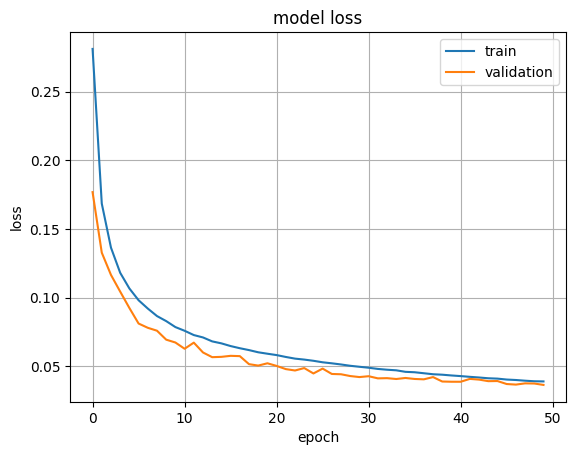

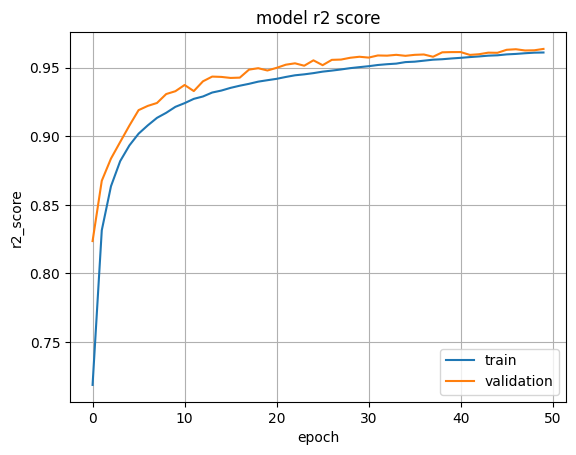

In [35]:
# loss
plt.plot(exolab.history['loss'])
plt.plot(exolab.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

# r2 score
plt.plot(exolab.history['r2_score'])
plt.plot(exolab.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [36]:
test_loss,test_mae,test_r2_score = model_100k.evaluate(X_test,y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0362 - mae: 0.1179 - r2_score: 0.9637


In [37]:
predictions = model_100k.predict(X_test)
predictions.shape

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(20000, 7)

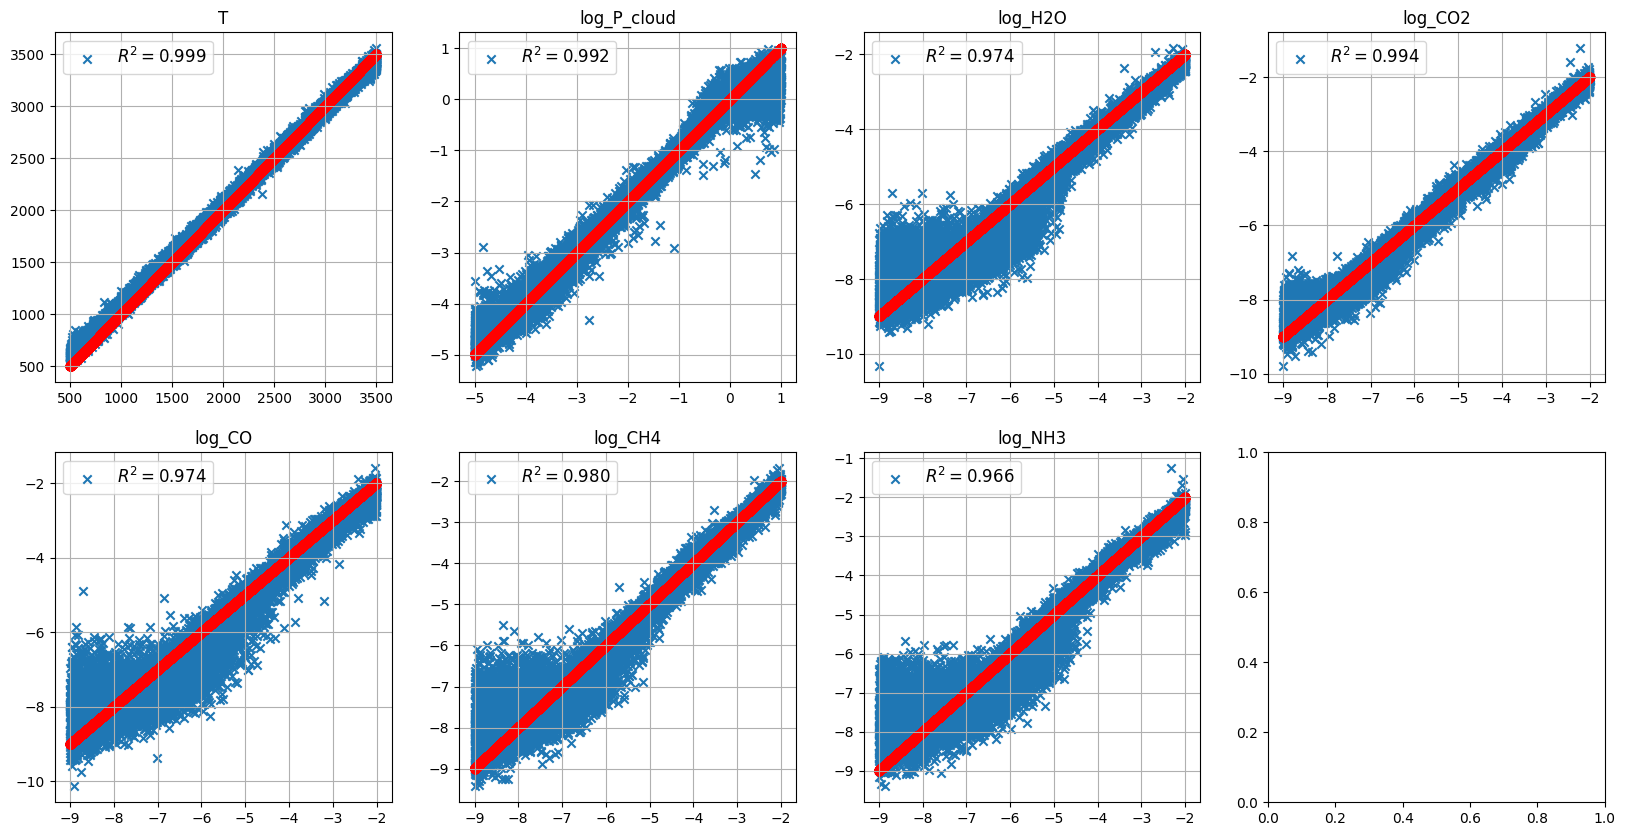

In [38]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

In [39]:
pred = model_100k.predict(test_planets)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


W0000 00:00:1725026161.778680      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(3, 7)

In [40]:
pred = scaler.inverse_transform(pred)

In [41]:
planetA_pred_100k = pred[0]
print("Predicted values:",planetA_pred_100k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.1044868e+03  4.5913079e-01 -7.2516026e+00 -8.1786833e+00
 -4.8831348e+00 -3.5874193e+00 -4.1580825e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [42]:
planetB_pred_100k = pred[1]
print("Predicted values:",planetB_pred_100k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1428076e+03  3.9131573e-01 -2.7780449e+00 -2.7287860e+00
 -8.6614532e+00 -5.7102785e+00 -5.2759461e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [43]:
planetC_pred_100k = pred[2]
print("Predicted values:",planetC_pred_100k)
print("Actual values:",planetC_params[3:])

Predicted values: [2697.4927      -2.9070394   -6.158178    -5.7815304   -6.952148
   -3.2897708   -6.3068466]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 1M Data

In [44]:
X = new_spec[:]
Y = new_data[:,272:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = scaler.fit_transform(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((796780, 274, 1), (199195, 274, 1), (796780, 7), (199195, 7))

In [45]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_1M = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(5e-5)
model_1M.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model_1M.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 272, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 136, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 134, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 67, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 65, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,130,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,178,119 (8.31 MB)

 Trainable params: 2,178,119 (8.31 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
exolab=model_1M.fit(X_train, y_train, epochs=25,batch_size=32,
                    validation_split=0.2,shuffle=True)

Epoch 1/25
19920/19920 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.2263 - mae: 0.3499 - r2_score: 0.7736 - val_loss: 0.0832 - val_mae: 0.1876 - val_r2_score: 0.9168
Epoch 2/25
19920/19920 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 0.0859 - mae: 0.2043 - r2_score: 0.9141 - val_loss: 0.0641 - val_mae: 0.1675 - val_r2_score: 0.9360
Epoch 3/25
19920/19920 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 0.0678 - mae: 0.1780 - r2_score: 0.9322 - val_loss: 0.0513 - val_mae: 0.1411 - val_r2_score: 0.9487
Epoch 4/25
19920/19920 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 0.0587 - mae: 0.1637 - r2_score: 0.9413 - val_loss: 0.0446 - val_mae: 0.1340 - val_r2_score: 0.9554
Epoch 5/25
19920/19920 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - loss: 0.0528 - mae: 0.1536 - r2_score: 0.9472 - val_loss: 0.0392 - val_mae: 0.1205 - val_r2_score: 0.9608
Epoch 6/25
19920/19920 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 0.0483 - mae: 0.1455 - r2_score: 0.9516 - val_loss: 0.0420 - val_mae: 0.1229 - val_r2_score: 0.9580
Epoch 7/25

In [47]:
model_1M.save("cnn_model_1M_m_s_p.keras")

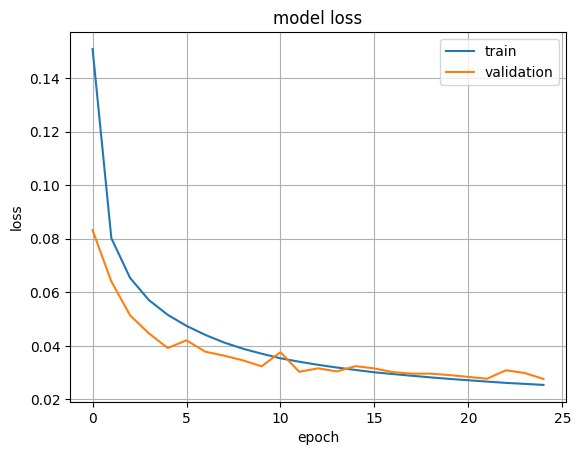

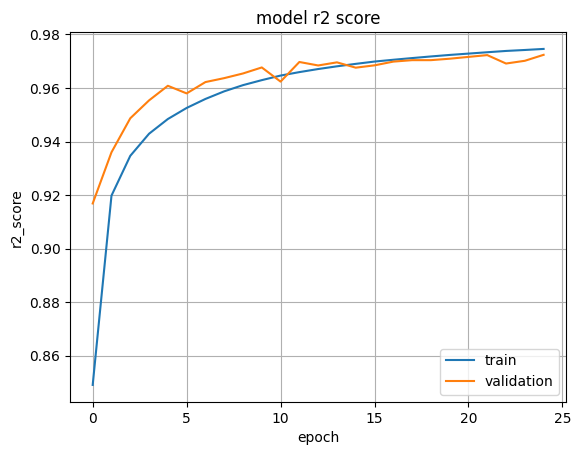

In [48]:
# loss
plt.plot(exolab.history['loss'])
plt.plot(exolab.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

# r2 score
plt.plot(exolab.history['r2_score'])
plt.plot(exolab.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [49]:
test_loss,test_mae,test_r2_score = model_1M.evaluate(X_test,y_test)

6225/6225 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0277 - mae: 0.1086 - r2_score: 0.9724


In [50]:
predictions = model_1M.predict(X_test)
predictions.shape

6225/6225 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


(199195, 7)

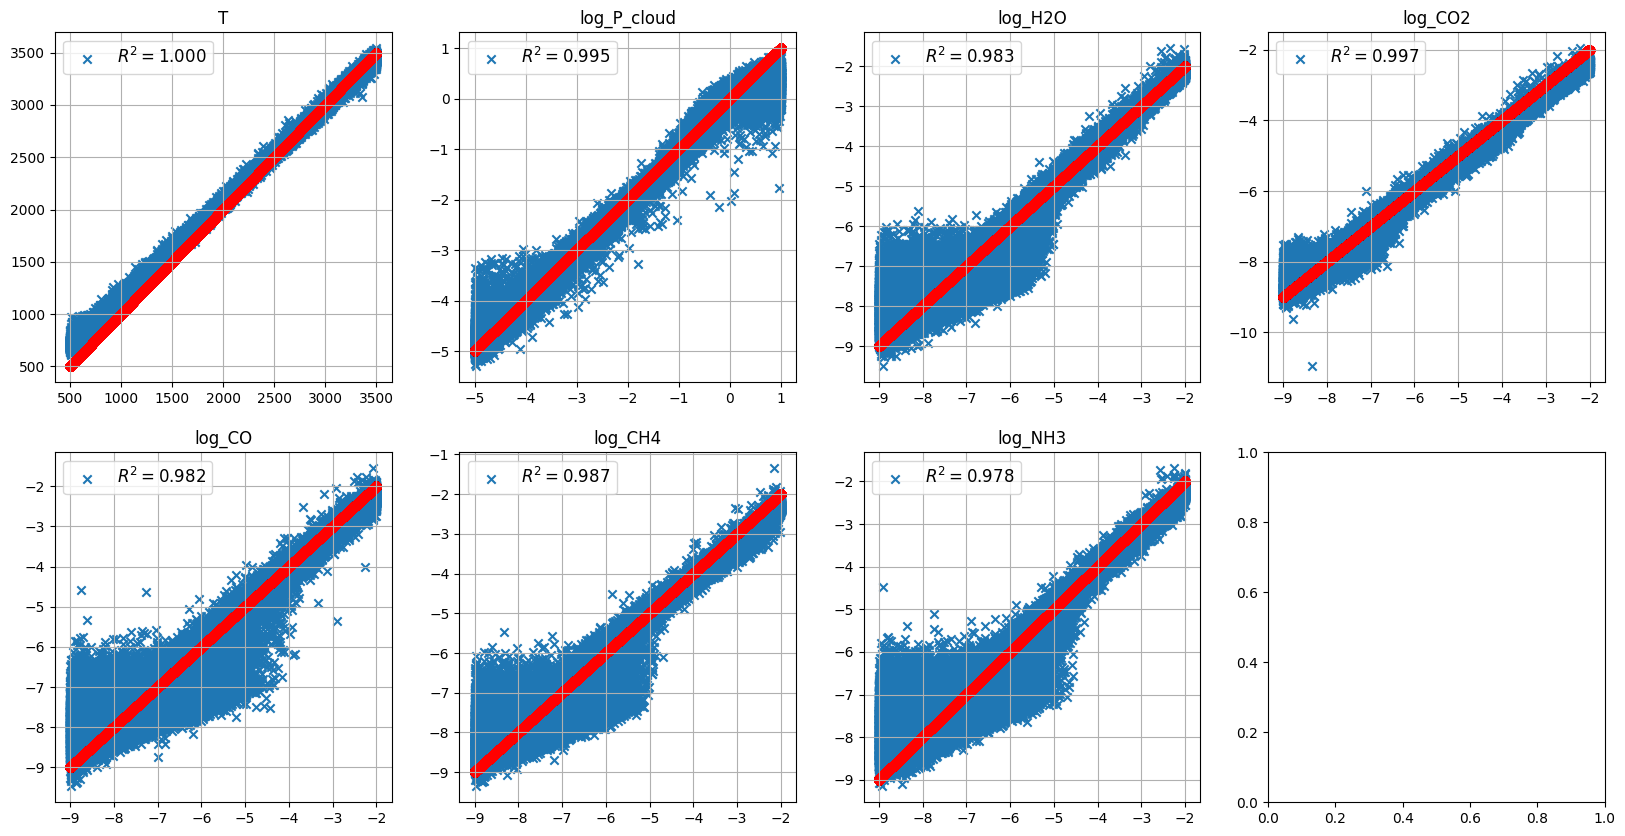

In [51]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

In [52]:
pred = model_1M.predict(test_planets)
pred = scaler.inverse_transform(pred)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


W0000 00:00:1725028138.894745      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(3, 7)

In [53]:
planetA_pred_1M = pred[0]
print("Predicted values:",planetA_pred_1M)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.1479175e+03  1.5833050e-01 -7.6789150e+00 -8.0022993e+00
 -4.9201689e+00 -3.7786372e+00 -4.2391076e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [54]:
planetB_pred_1M = pred[1]
print("Predicted values:",planetB_pred_1M)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.2755184e+03  1.8409616e-01 -2.8712690e+00 -3.0789375e+00
 -7.3771067e+00 -5.8023148e+00 -5.1377320e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [55]:
planetC_pred_1M = pred[2]
print("Predicted values:",planetC_pred_1M)
print("Actual values:",planetC_params[3:])

Predicted values: [2659.6736      -3.201251    -5.642618    -5.455313    -5.9803033
   -3.1170294   -5.269996 ]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


### Comparison plots

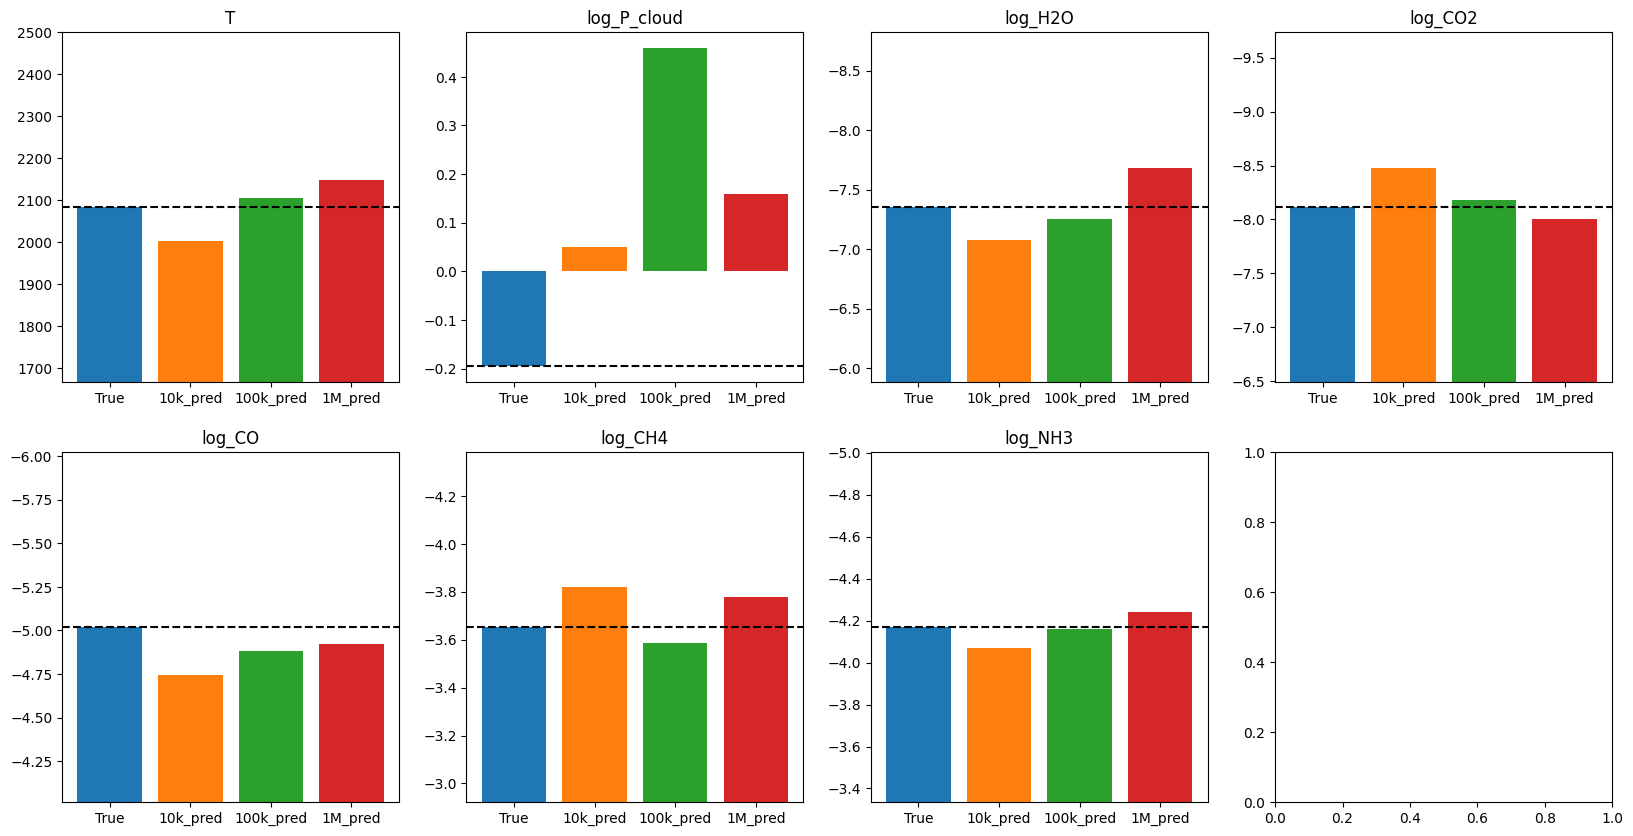

In [56]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetA_params[3],1.20*planetA_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetA_params[3+i])
        axs[1,i-4].bar(labels2, planetA_pred_10k[i])
        axs[1,i-4].bar(labels3, planetA_pred_100k[i])
        axs[1,i-4].bar(labels4, planetA_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
        
plt.savefig('comparison_plot1.png')

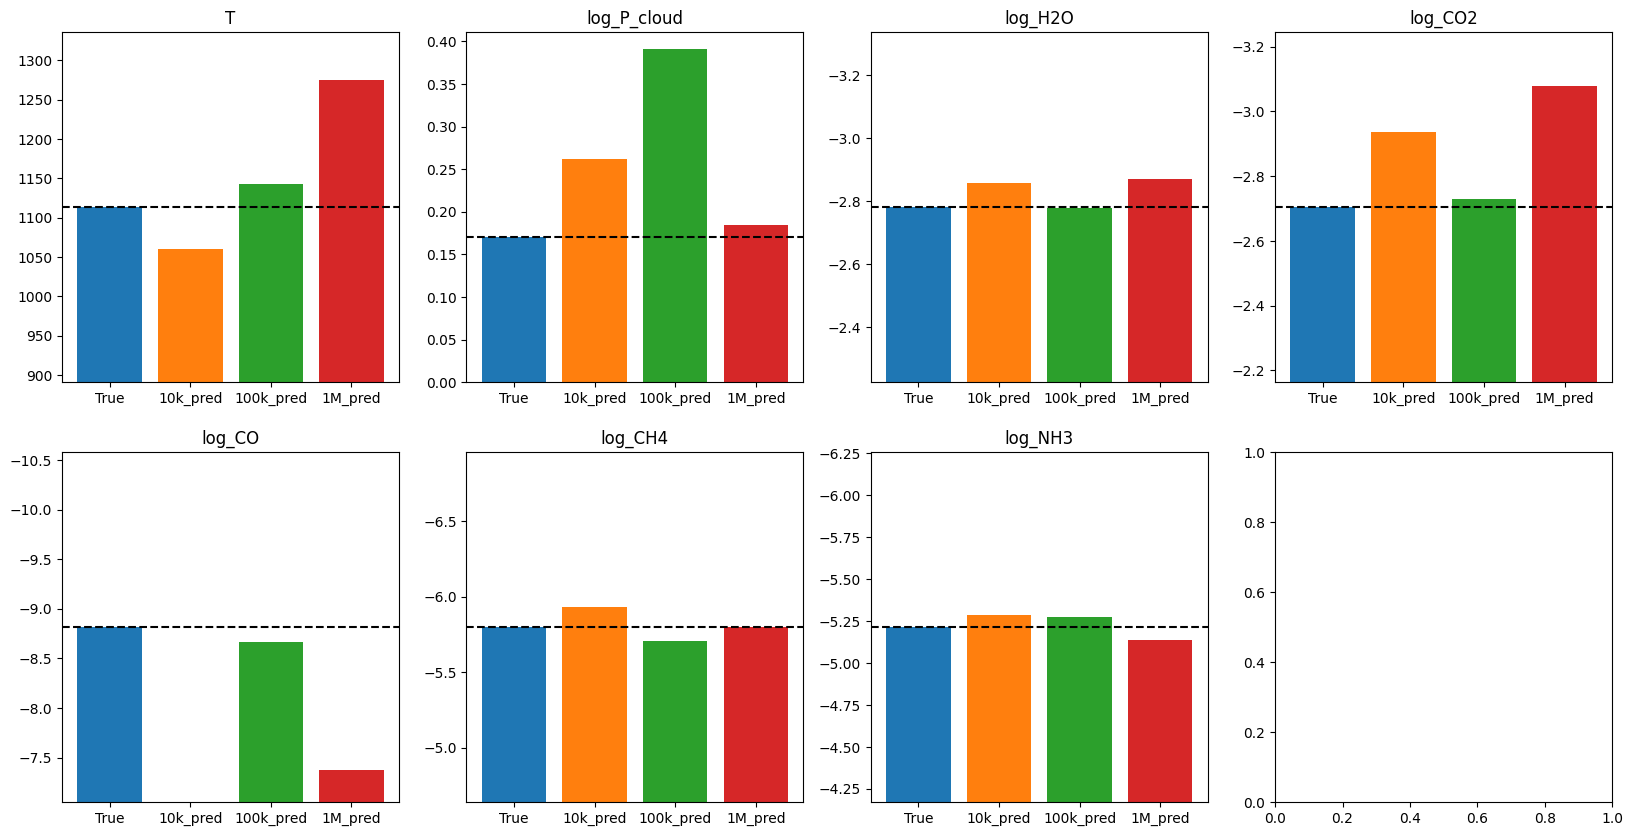

In [57]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetB_params[3],1.20*planetB_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetB_params[3+i])
        axs[1,i-4].bar(labels2, planetB_pred_10k[i])
        axs[1,i-4].bar(labels3, planetB_pred_100k[i])
        axs[1,i-4].bar(labels4, planetB_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
        
plt.savefig('comparison_plot2.png')

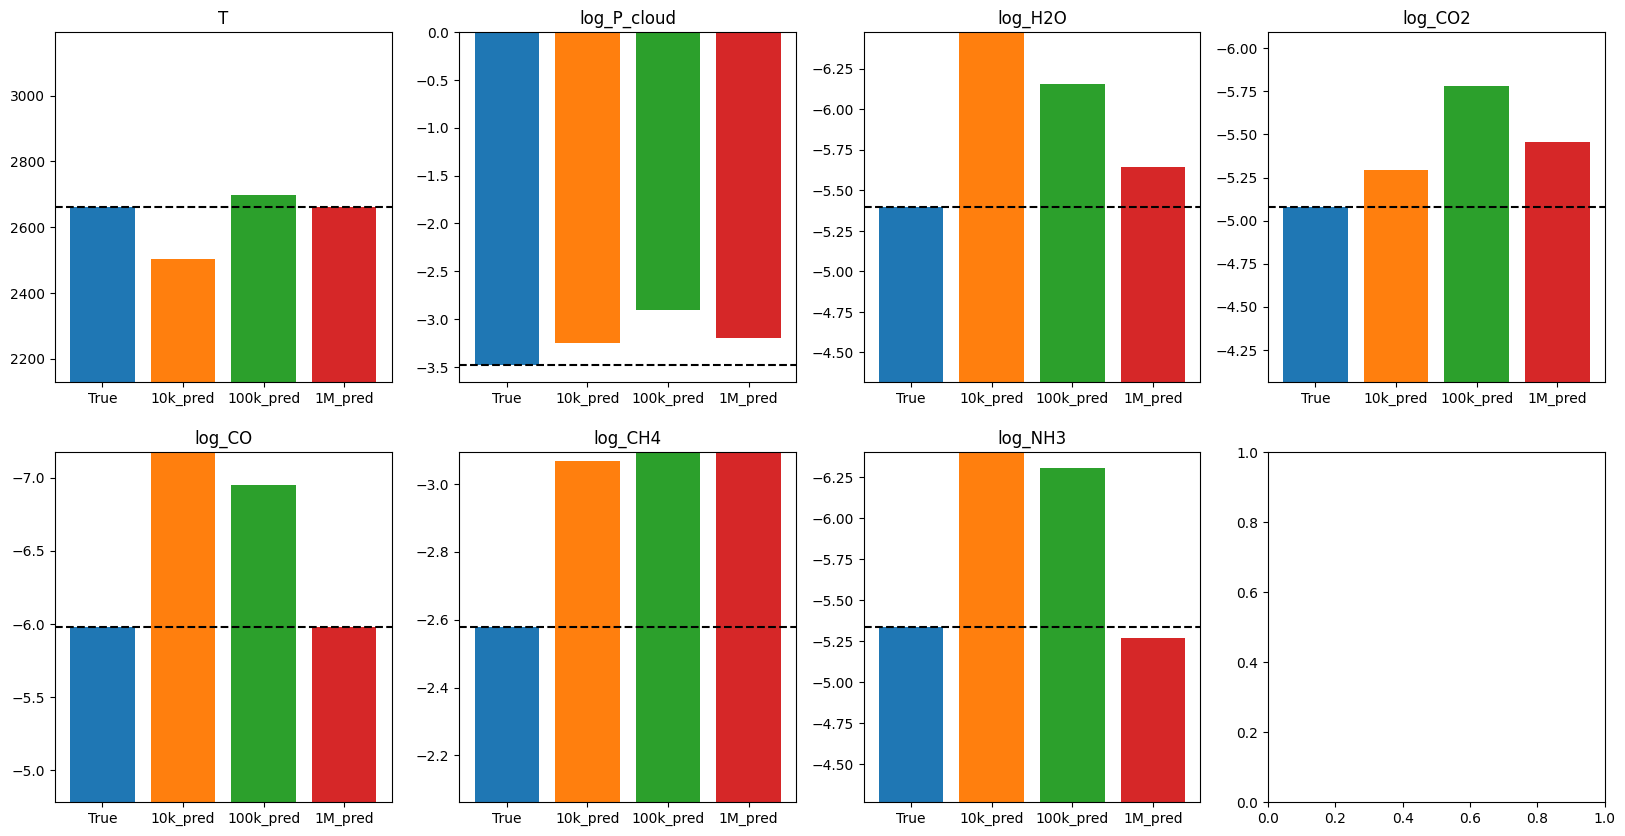

In [58]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetC_params[3],1.20*planetC_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetC_params[3+i])
        axs[1,i-4].bar(labels2, planetC_pred_10k[i])
        axs[1,i-4].bar(labels3, planetC_pred_100k[i])
        axs[1,i-4].bar(labels4, planetC_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
        
plt.savefig('comparison_plot3.png')